<a href="https://colab.research.google.com/github/David-Carballo/2023w-project-pose/blob/main/AnglesMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup Kaggle
Load kaggle.json file with your Kaggle API Token in Settings>Account>Create New API Token

### Install the Kaggle library

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# make a directory named ".kaggle"
! mkdir ~/.kaggle
# copy the "kaggle.json" file into this new directory
! cp kaggle.json ~/.kaggle/
# allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

### Upload Kaggle Dataset

In [ ]:
#Load kaggle.json file with your Kaggle API Token in Settings>Account>Create New API Token
! kaggle datasets download tr1gg3rtrash/yoga-posture-dataset
#unzip dataset
! mkdir data
! unzip yoga-posture-dataset.zip -d data/

Translate Sanskrit names to English names

In [4]:
import json
import os

poses_dict = {}

with open('data/Poses.json') as f:
    data = json.load(f)
    for pose in data['Poses']:
        poses_dict[pose['sanskrit_name']] = pose['english_name']
    
print(poses_dict)

{'Navasana': 'Boat', 'Ardha Navasana': 'Half-Boat', 'Dhanurasana': 'Bow', 'Setu Bandha Sarvangasana': 'Bridge', 'Baddha Konasana': 'Butterfly', 'Ustrasana': 'Camel', 'Marjaryasana': 'Cat', 'Bitilasana': 'Cow', 'Utkatasana': 'Chair', 'Balasana': "Child's Pose", 'Sivasana': 'Corpse', 'Alanasana': 'Crescent Lunge', 'Bakasana': 'Crow', 'Ardha Pincha Mayurasana': 'Dolphin', 'Adho Mukha Svanasana': 'Downward-Facing Dog', 'Garudasana': 'Eagle', 'Utthita Hasta Padangusthasana': 'Extended Hand to Toe', 'Utthita Parsvakonasana': 'Extended Side Angle', 'Pincha Mayurasana': 'Forearm Stand', 'Uttanasana': 'Standing Forward Bend', 'Ardha Chandrasana': 'Half-Moon', 'Adho Mukha Vrksasana': 'Handstand', 'Anjaneyasana': 'Low Lunge', 'Supta Kapotasana': 'Pigeon', 'Eka Pada Rajakapotasana': 'King Pigeon', 'Phalakasana': 'Plank', 'Halasana': 'Plow', 'Parsvottanasana': 'Pyramid', 'Parsva Virabhadrasana': 'Reverse Warrior', 'Paschimottanasana': 'Seated Forward Bend', 'Padmasana': 'Lotus', 'Ardha Matsyendrasa

# 1. Dataset

## 1.0. Import
Import libraries, OpenPoseModel and set up hyperparameters


In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision.transforms as transforms
import albumentations as A
import numpy as np
from PIL import Image
import os
import random

import math

##1.1 Compute keypoints
Extract keypoints of the images from dataset.

In [67]:
#Load OpenPose Model
!pip install git+https://github.com/prasunroy/openpose-pytorch.git

from openpose.body.estimator import BodyPoseEstimator, BodyPoseModel
from openpose.utils import draw_body_connections, draw_keypoints
import cv2

import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/prasunroy/openpose-pytorch.git to /tmp/pip-req-build-if04tx_x
  Running command git clone --filter=blob:none --quiet https://github.com/prasunroy/openpose-pytorch.git /tmp/pip-req-build-if04tx_x
  Resolved https://github.com/prasunroy/openpose-pytorch.git to commit 8955ef1d220d5dc43dd5e573a49e323393ae5446
  Preparing metadata (setup.py) ... done


###Get keypoints from all images

In [68]:
data_dir = 'data'
model = BodyPoseModel()
estimator = BodyPoseEstimator(pretrained=True)

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

BodyPoseModel(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=(

In [ ]:
index = 0
keypoints = torch.empty(2756,18,3)
#Loop through yoga class names
for i, subdir in enumerate(sorted(os.listdir(data_dir))):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        # loop through each image of the class
        for file in sorted(os.listdir(subdir_path)):
            file_path = os.path.join(subdir_path, file)
            if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                tic = time.perf_counter()
                img = cv2.imread(file_path)
                height, width = img.shape[:2]
                if height > 500 or width > 500:
                    scale_factor = 500.0 / width
                    new_width = int(width * scale_factor)
                    new_height = int(height * scale_factor)
                    # Redimensionar la imagen con el mismo factor de escala en ambas dimensiones
                    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
                kps = estimator(img)
                toc = time.perf_counter()
                print(f'{index}-{index/2758*100}% -> Img: {file} in {subdir} = {toc - tic:0.4f} seconds')
                if len(kps) == 0:
                    kps = torch.zeros([1,18,3])
                else:
                    kps = torch.from_numpy(kps[0])
                keypoints[index] = kps
                index += 1

0-0.0% -> Img: File1.png in Adho Mukha Svanasana = 4.9994 seconds
1-0.03625815808556925% -> Img: File10.png in Adho Mukha Svanasana = 2.1960 seconds
2-0.0725163161711385% -> Img: File11.png in Adho Mukha Svanasana = 2.8395 seconds
3-0.10877447425670776% -> Img: File12.png in Adho Mukha Svanasana = 2.2625 seconds
4-0.145032632342277% -> Img: File13.png in Adho Mukha Svanasana = 2.3387 seconds
5-0.18129079042784627% -> Img: File14.png in Adho Mukha Svanasana = 2.2032 seconds
6-0.21754894851341552% -> Img: File15.png in Adho Mukha Svanasana = 2.2082 seconds
7-0.25380710659898476% -> Img: File16.png in Adho Mukha Svanasana = 2.3731 seconds
8-0.290065264684554% -> Img: File17.png in Adho Mukha Svanasana = 3.1820 seconds
9-0.3263234227701233% -> Img: File18.png in Adho Mukha Svanasana = 2.0567 seconds
10-0.36258158085569253% -> Img: File19.png in Adho Mukha Svanasana = 1.8445 seconds
11-0.3988397389412618% -> Img: File2.png in Adho Mukha Svanasana = 2.4010 seconds
12-0.43509789702683105% -> 

/usr/local/lib/python3.9/dist-packages/openpose/body/estimator.py:210: RuntimeWarning: invalid value encountered in true_divide
  v = np.divide(v, n)
/usr/local/lib/python3.9/dist-packages/openpose/body/estimator.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  score_with_dist_prior = sum(score_midpoints) / len(score_midpoints) + min(0.5 * image.shape[0] / n - 1, 0)


53-1.9216823785351704% -> Img: File58.png in Adho Mukha Svanasana = 2.1924 seconds
54-1.9579405366207396% -> Img: File59.png in Adho Mukha Svanasana = 1.9276 seconds
55-1.9941986947063088% -> Img: File6.png in Adho Mukha Svanasana = 2.2114 seconds
56-2.030456852791878% -> Img: File60.png in Adho Mukha Svanasana = 2.2284 seconds
57-2.0667150108774472% -> Img: File61.png in Adho Mukha Svanasana = 2.1072 seconds
58-2.102973168963017% -> Img: File62.png in Adho Mukha Svanasana = 3.2106 seconds
59-2.139231327048586% -> Img: File63.png in Adho Mukha Svanasana = 2.0796 seconds
60-2.1754894851341553% -> Img: File64.png in Adho Mukha Svanasana = 2.1796 seconds
61-2.2117476432197245% -> Img: File65.png in Adho Mukha Svanasana = 1.4860 seconds
62-2.2480058013052937% -> Img: File66.png in Adho Mukha Svanasana = 1.7859 seconds
63-2.284263959390863% -> Img: File67.png in Adho Mukha Svanasana = 2.1460 seconds
64-2.320522117476432% -> Img: File68.png in Adho Mukha Svanasana = 3.3880 seconds
65-2.35678

In [ ]:
torch.save(keypoints,'keypoints')

##1.2 Load Keypoints

In [7]:
load_keypoints = torch.load('keypoints')

In [ ]:
load_keypoints[50]

tensor([[  0.,   0.,   0.],
        [198., 139.,   1.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [180., 139.,   1.],
        [130., 211.,   1.],
        [ 82., 262.,   1.],
        [282.,  47.,   1.],
        [350., 144.,   1.],
        [393., 236.,   1.],
        [294.,  52.,   1.],
        [351., 145.,   1.],
        [405., 241.,   1.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]])

##1.3 Compute Angles

In [9]:
import math

#Given the points A,B and C, compute the angle formed by the vectors AB and BC
def compute_angle(ax,ay, bx,by, cx,cy):
    dot_product = (bx - ax) * (cx - bx) + (by - ay) * (cy - by)
    mag0 = math.sqrt((bx - ax)**2 + (by - ay)**2)
    mag1 = math.sqrt((cx - bx)**2 + (cy - by)**2)
    angle = math.acos(dot_product / (mag0 * mag1))

    return angle

#Given the keypoints of the pose, calculate its angle
def get_angles(keypoints):
    n = len(keypoints)
    output = torch.empty(n,13)
    
    i = 0
    for kps in keypoints:
        #Connections of each vector
        connections =  [(0,1,2), (1,2,3), (2,3,4), (0,1,5), (1,5,6), (5,6,7), (1,2,8), (2,8,9), (8,9,10), (1,5,11), (5,11,12), (11,12,13)]

        angles = []
        #Get horizontal reference for first angle
        Ax = kps[0][0] - 20
        Ay = kps[0][1]
        Bx = kps[0][0]
        By = kps[0][1]
        Cx = kps[1][0]
        Cy = kps[1][1]
        first_angle = compute_angle(Ax, Ay, Bx, By, Cx, Cy)
        angles.append(first_angle)
        #Get rest of angles
        for a,b,c in connections:
            Ax = kps[a][0]
            Ay = kps[a][1]
            Bx = kps[b][0]
            By = kps[b][1]
            Cx = kps[c][0]
            Cy = kps[c][1]
            
            angle_deg = compute_angle(Ax, Ay, Bx, By, Cx, Cy)
            angles.append(angle_deg)
        output[i] = torch.FloatTensor(angles)
        i +=1
    output = torch.nan_to_num(output)
    return output

Test angles

In [ ]:
angles = get_angles(load_keypoints)

images = []
labels = []
for i, subdir in enumerate(sorted(os.listdir('data'))):
          subdir_path = os.path.join('data', subdir)
          if os.path.isdir(subdir_path):
              for file in sorted(os.listdir(subdir_path)):
                  file_path = os.path.join(subdir_path, file)
                  if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                      images.append(file_path)
                      labels.append(i)

pose = 0
count = 0
empty = 0
total_empty = 0
total_angles = 0
for i in range(0, len(labels)):
  n = torch.count_nonzero(angles[i])
  if n == 0:
      empty +=1
  total_angles += n
  count += 1
  if pose != labels[i]:
    pose = labels[i]
    #print(f'Class {pose} until position {i} with {count-1} images and {total_angles/count-1} average angles. No poses {empty}/{count-1}')
    print(f'Class {pose} with {count-1} images and {total_angles/count-1} average angles. No poses {empty}/{count-1} = {(empty/(count-1))*100}%')
    count = 0
    total_empty += empty
    empty = 0
    total_angles = 0
print(f'Class {pose+1} in position {i} with {count} images')
print(total_empty, total_empty/(2756)*100)

Class 1 with 74 images and 4.146666526794434 average angles. No poses 32/74 = 43.24324324324324%
Class 2 with 64 images and 4.169230937957764 average angles. No poses 30/64 = 46.875%
Class 3 with 17 images and 10.222222328186035 average angles. No poses 1/17 = 5.88235294117647%
Class 4 with 70 images and 10.830986022949219 average angles. No poses 3/70 = 4.285714285714286%
Class 5 with 58 images and 10.677966117858887 average angles. No poses 5/58 = 8.620689655172415%
Class 6 with 95 images and 11.1875 average angles. No poses 2/95 = 2.1052631578947367%
Class 7 with 12 images and 7.538461685180664 average angles. No poses 4/12 = 33.33333333333333%
Class 8 with 53 images and 4.592592716217041 average angles. No poses 21/53 = 39.62264150943396%
Class 9 with 11 images and 10.25 average angles. No poses 1/11 = 9.090909090909092%
Class 10 with 80 images and 10.24691390991211 average angles. No poses 7/80 = 8.75%
Class 11 with 83 images and 9.7380952835083 average angles. No poses 3/83 = 3.6

##1.4 Dataset

In [48]:
!rm 'data/Poses.json'

class AnglesDataset(Dataset):
    def __init__(self, data_dir, transforms=False, train=0, keypoints=None):
        self.data_dir = data_dir
        self.transforms = transforms

        self.train = train
        self.images, self.labels, self.angles = self.load_data(data_dir,keypoints)
         
    def __getitem__(self, index):
        ang = self.angles[index]
        
        if self.transforms == True:
            if random.random() < 0.75:
                ang = self.add_noise(ang,30)

        return ang, self.labels[index]

    def load_data(self, data_dir, keypoints):
        images = []
        labels = []
        for i, subdir in enumerate(sorted(os.listdir(data_dir))):
                    subdir_path = os.path.join(data_dir, subdir)
                    if os.path.isdir(subdir_path):
                        for file in sorted(os.listdir(subdir_path)):
                            file_path = os.path.join(subdir_path, file)
                            if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                                images.append(file_path)
                                labels.append(i)
        angles = get_angles(keypoints)

        #Shuffle images
        random.seed(1)
        
        idx = [x for x in range(0,2756)]
        random.shuffle(idx)

        data = []
        new_labels = []
        new_keypoints = []
        new_angles = []
        for i in idx:
            data.append(images[i])
            new_labels.append(labels[i])
            new_angles.append(angles[i])
        
        n = int(len(images) * 0.6)
        aux = int(len(images) * 0.2)
        m = n+aux
        print(idx[n])
        if self.train == 0:
          return data[:n], new_labels[:n], new_angles[:n]
        elif self.train == 1:
          return data[n:m], new_labels[n:m], new_angles[n:m]
        else:
          return data[m:], new_labels[m:], new_angles[m:]

    def get_images(self):
      return self.images
    
    def get_labels(self):
      return self.labels

    def add_noise(self, angles, alpha):
        new_ang = angles.clone()
        n = random.uniform(-alpha,alpha) * math.pi / 180
        
        for i,a in enumerate(angles):
            if angles[i] > 0:
                new_ang[i] = max(0, angles[i] + n)
        return new_ang
    
    def __len__(self):
        return len(self.images)

rm: cannot remove 'data/Poses.json': No such file or directory


In [49]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':750,
    'test_batch_size':64,
    'hidden_size':32,
    'num_classes':47,
    'num_inputs':13,
    'learning_rate':0.001,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [47]:
# Test Dataset class (train = 0 -> Training dataset, 1 -> Validation Dataset, 2 -> Test Dataset)
angles_train_dataset = AnglesDataset('data', transforms = True, train = 0, keypoints=load_keypoints)
angles_val_dataset = AnglesDataset('data', transforms = False, train = 1, keypoints=load_keypoints)
angles_test_dataset = AnglesDataset('data', transforms = False, train = 2, keypoints=load_keypoints)

2316
2316
2316


In [50]:
train_loader = DataLoader(dataset=angles_train_dataset, batch_size=hparams['batch_size'], shuffle=False)
val_loader = DataLoader(dataset=angles_val_dataset, batch_size=hparams['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=angles_test_dataset, batch_size=hparams['batch_size'], shuffle=False)

# 2. MLP Model

In [51]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.batch = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size*2, output_size)
        

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch(self.relu1(out))
        out = self.drop(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop(out)
        out = self.fc3(out)
        return out

In [52]:
mlp = MLP(hparams['num_inputs'], hparams['hidden_size'] ,hparams['num_classes'])
mlp.to(hparams['device'])

MLP(
  (batch): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (relu1): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=47, bias=True)
)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), hparams['learning_rate'])

##Training and Validation

In [54]:
import matplotlib.pyplot as plt

In [55]:
def validate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print validation statistics
    #print('Validation Loss: %.3f, Accuracy: %.3f' % (running_loss / len(val_loader), accuracy))

    return accuracy

In [56]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
  
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update train loss and accuracy once per epoch
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
        # Run validation loop once per epoch and update val accuracy
        val_acc = validate(model, val_loader, criterion, device)
        val_acc_list.append(val_acc)

        if epoch % 10 == 0:
            print('[Epoch %d] Train Loss: %.3f, Train Acc: %.3f, Val Acc: %.3f' %
              (epoch, train_loss, train_acc, val_acc))

    # Plot train and val accuracy once training is finished
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Validation'])
    plt.show()

    print('Finished Training')

[Epoch 0] Train Loss: 3.884, Train Acc: 3.569, Val Acc: 4.900
[Epoch 10] Train Loss: 2.766, Train Acc: 27.707, Val Acc: 26.860
[Epoch 20] Train Loss: 2.314, Train Acc: 38.959, Val Acc: 35.209
[Epoch 30] Train Loss: 1.979, Train Acc: 47.489, Val Acc: 37.024
[Epoch 40] Train Loss: 1.751, Train Acc: 51.361, Val Acc: 39.746
[Epoch 50] Train Loss: 1.605, Train Acc: 55.656, Val Acc: 40.109
[Epoch 60] Train Loss: 1.476, Train Acc: 58.076, Val Acc: 40.109
[Epoch 70] Train Loss: 1.381, Train Acc: 61.283, Val Acc: 39.564
[Epoch 80] Train Loss: 1.293, Train Acc: 63.158, Val Acc: 40.109
[Epoch 90] Train Loss: 1.231, Train Acc: 64.610, Val Acc: 39.383
[Epoch 100] Train Loss: 1.146, Train Acc: 67.453, Val Acc: 39.564
[Epoch 110] Train Loss: 1.080, Train Acc: 68.119, Val Acc: 39.201
[Epoch 120] Train Loss: 1.027, Train Acc: 70.659, Val Acc: 39.927
[Epoch 130] Train Loss: 0.972, Train Acc: 72.414, Val Acc: 39.383
[Epoch 140] Train Loss: 0.920, Train Acc: 74.471, Val Acc: 39.020
[Epoch 150] Train Loss:

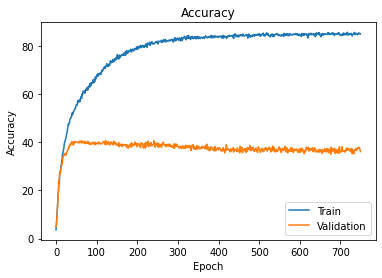

Finished Training


In [57]:
train(mlp, train_loader, val_loader, criterion, optimizer, hparams['device'], hparams['num_epochs'])

In [60]:
def test(model, test_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy

In [61]:
test(mlp, test_loader, criterion, hparams['device'])

36.116152450090745

#Metrics

In [97]:
sorted(list(poses_dict.keys()))

['Adho Mukha Svanasana',
 'Adho Mukha Vrksasana',
 'Alanasana',
 'Anjaneyasana',
 'Ardha Chandrasana',
 'Ardha Matsyendrasana',
 'Ardha Navasana',
 'Ardha Pincha Mayurasana',
 'Ashta Chandrasana',
 'Baddha Konasana',
 'Bakasana',
 'Balasana',
 'Bitilasana',
 'Camatkarasana',
 'Dhanurasana',
 'Eka Pada Rajakapotasana',
 'Garudasana',
 'Halasana',
 'Hanumanasana',
 'Malasana',
 'Marjaryasana',
 'Navasana',
 'Padmasana',
 'Parsva Virabhadrasana',
 'Parsvottanasana',
 'Paschimottanasana',
 'Phalakasana',
 'Pincha Mayurasana',
 'Salamba Bhujangasana',
 'Salamba Sarvangasana',
 'Setu Bandha Sarvangasana',
 'Sivasana',
 'Supta Kapotasana',
 'Trikonasana',
 'Upavistha Konasana',
 'Urdhva Dhanurasana',
 'Urdhva Mukha Svsnssana',
 'Ustrasana',
 'Utkatasana',
 'Uttanasana',
 'Utthita Hasta Padangusthasana',
 'Utthita Parsvakonasana',
 'Vasisthasana',
 'Virabhadrasana One',
 'Virabhadrasana Three',
 'Virabhadrasana Two',
 'Vrksasana']

In [75]:
classes = list(range(0,47))

In [74]:
classes

[range(0, 47)]

40.39855072463768


<Axes: >

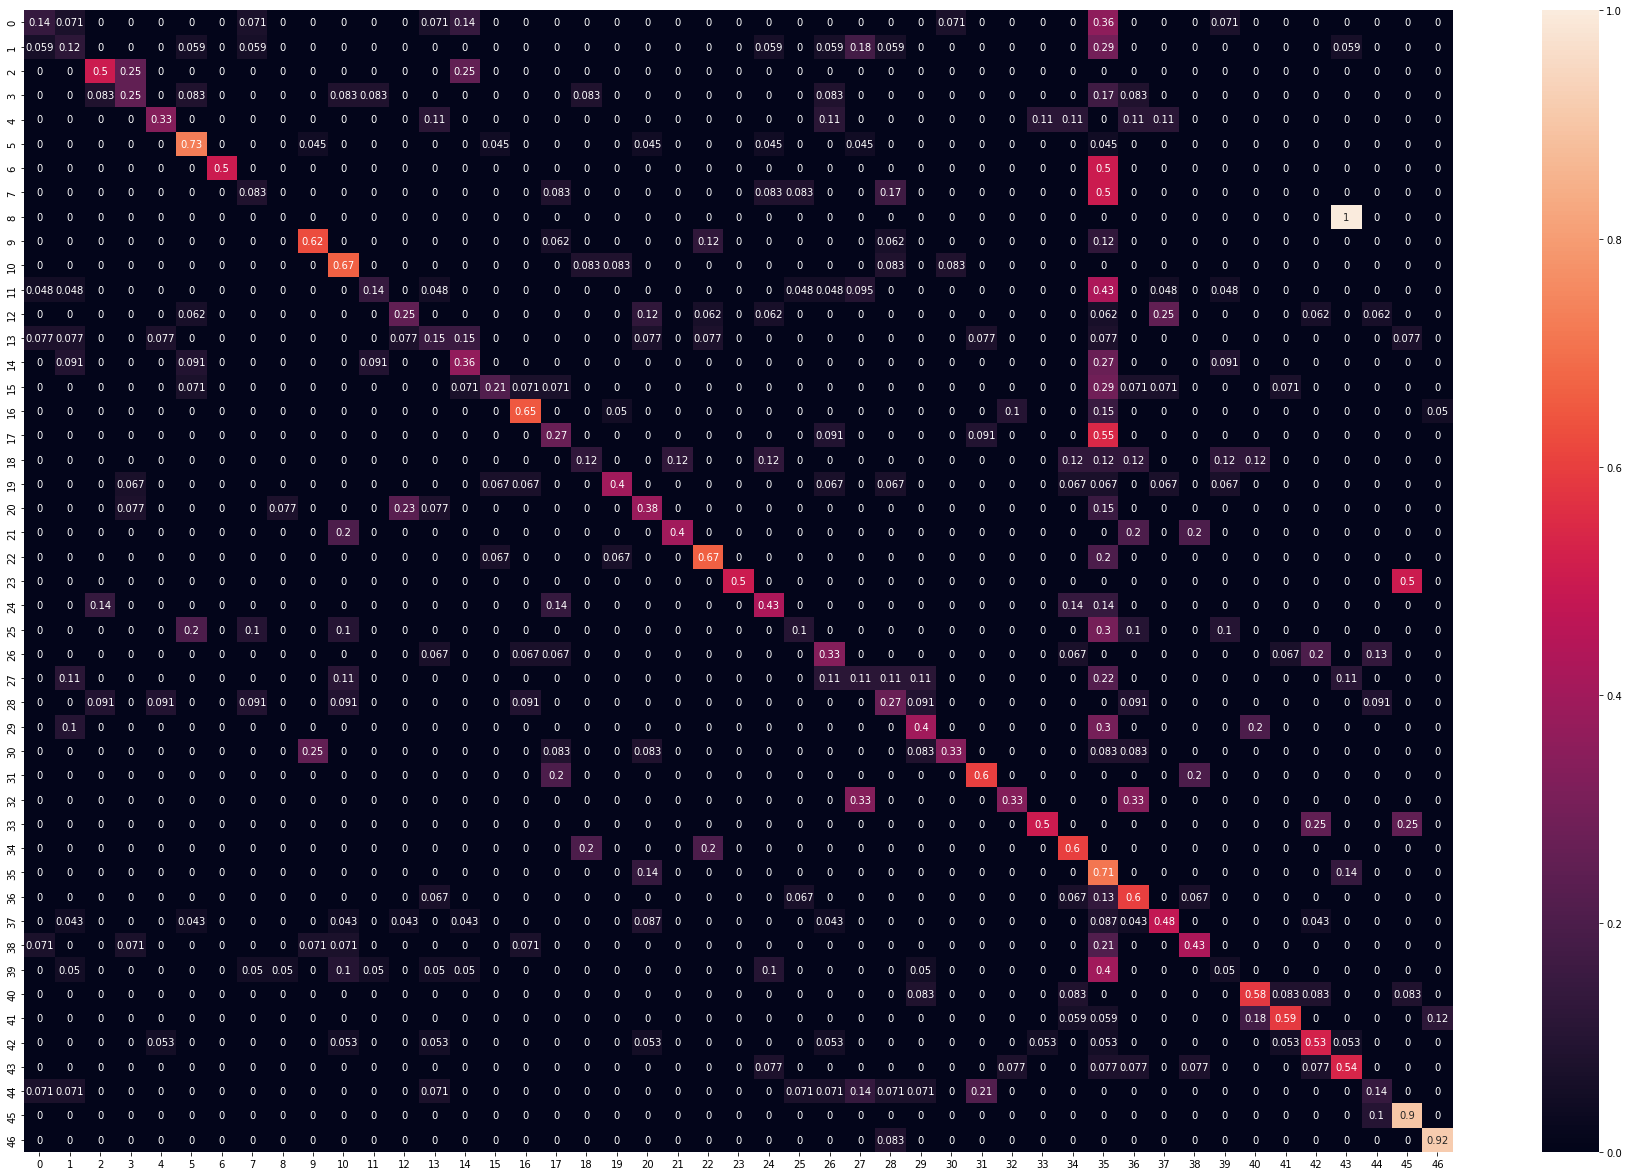

In [99]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = mlp(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes

print(accuracy_score(y_true, y_pred)*100)


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (32,21))
sn.heatmap(df_cm, annot=True)

F1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.

The support is the number of samples of the true response that lie in that class.

In [100]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

target_names = sorted(list(poses_dict.keys()))
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

                               precision    recall  f1-score   support

         Adho Mukha Svanasana     0.2857    0.1429    0.1905        14
         Adho Mukha Vrksasana     0.1818    0.1176    0.1429        17
                    Alanasana     0.4000    0.5000    0.4444         4
                 Anjaneyasana     0.4286    0.2500    0.3158        12
            Ardha Chandrasana     0.5000    0.3333    0.4000         9
         Ardha Matsyendrasana     0.6667    0.7273    0.6957        22
               Ardha Navasana     1.0000    0.5000    0.6667         2
      Ardha Pincha Mayurasana     0.1667    0.0833    0.1111        12
            Ashta Chandrasana     0.0000    0.0000    0.0000         1
              Baddha Konasana     0.6667    0.6250    0.6452        16
                     Bakasana     0.4444    0.6667    0.5333        12
                     Balasana     0.5000    0.1429    0.2222        21
                   Bitilasana     0.4444    0.2500    0.3200        16
     

In [92]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.14285714, 0.11764706, 0.5       , 0.25      , 0.33333333,
       0.72727273, 0.5       , 0.08333333, 0.        , 0.625     ,
       0.66666667, 0.14285714, 0.25      , 0.15384615, 0.36363636,
       0.21428571, 0.65      , 0.27272727, 0.125     , 0.4       ,
       0.38461538, 0.4       , 0.66666667, 0.5       , 0.42857143,
       0.1       , 0.33333333, 0.11111111, 0.27272727, 0.4       ,
       0.33333333, 0.6       , 0.33333333, 0.5       , 0.6       ,
       0.71428571, 0.6       , 0.47826087, 0.42857143, 0.05      ,
       0.58333333, 0.58823529, 0.52631579, 0.53846154, 0.14285714,
       0.9       , 0.91666667])